#Pipeline destinado ao estudo de dados desbalanceados + classificação multirrótulo

# 📘 **Resumo do Dataset e do Pipeline**

Este trabalho utiliza o **Adult Dataset (UCI Repository)**, um conjunto de dados composto por informações socioeconômicas e demográficas de mais de 48 mil indivíduos. O objetivo original do dataset é **prever se a renda anual de um indivíduo supera 50 mil dólares**, porém, neste estudo, o conjunto de dados é reestruturado para analisar um problema mais complexo: **classificação multirrótulo com dados desbalanceados**.

O dataset contém variáveis como idade, escolaridade, estado civil, ocupação, sexo, raça, país de origem e horas trabalhadas por semana.

Neste trabalho, três rótulos binários são definidos a partir das variáveis originais, compondo um problema **multirrótulo**:

1. **high_income** — indica se a renda anual é maior que $50k;
2. **long_hours** — identifica pessoas que trabalham mais de 40h/semana;
3. **high_education** — indica escolaridade elevada (education-num ≥ 13).

Esses rótulos apresentam correlação entre si e níveis distintos de desbalanceamento, permitindo investigar como modelos multilabel lidam com diferentes distribuições.

O pipeline desenvolvido inclui:

* **Carregamento e limpeza do dataset**, com tratamento explícito de valores inconsistentes em variáveis de renda;
* **Construção dos três rótulos multirrótulo**, verificando sua distribuição e correlação;
* **Divisão estratificada em treino e teste**, mantendo a proporção adequada da classe de renda;
* **Pré-processamento com ColumnTransformer**, combinando padronização de atributos numéricos e One-Hot Encoding para atributos categóricos;
* **Aplicação de duas abordagens para o problema multilabel**:

  * **Binary Relevance + class_weight='balanced'** usando Regressão Logística;
  * **Binary Relevance + MLSMOTE**, realizando oversampling multirrótulo para equilibrar combinações raras de rótulos;
* **Avaliação com métricas específicas para classificação multirrótulo**, incluindo Hamming Loss, F1-micro, F1-macro e relatório por rótulo;
* **Visualização gráfica**, observando distribuições, correlações, matrizes de confusão e efeitos do balanceamento.

O objetivo final é comparar como modelos tradicionais com pesos balanceados versus técnicas mais avançadas de reamostragem multirrótulo influenciam o desempenho em cenários reais de **desbalanceamento e correlação entre rótulos**, gerando insights sobre práticas adequadas para problemas multilabel na vida real.

In [1]:
!pip install ucimlrepo

In [2]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
adult = fetch_ucirepo(id=2)

# data (as pandas dataframes)
X = adult.data.features
y = adult.data.targets

# metadata
print(adult.metadata)

# variable information
print(adult.variables)


{'uci_id': 2, 'name': 'Adult', 'repository_url': 'https://archive.ics.uci.edu/dataset/2/adult', 'data_url': 'https://archive.ics.uci.edu/static/public/2/data.csv', 'abstract': 'Predict whether annual income of an individual exceeds $50K/yr based on census data. Also known as "Census Income" dataset. ', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 48842, 'num_features': 14, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'], 'target_col': ['income'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1996, 'last_updated': 'Tue Sep 24 2024', 'dataset_doi': '10.24432/C5XW20', 'creators': ['Barry Becker', 'Ronny Kohavi'], 'intro_paper': None, 'additional_info': {'summary': "Extraction was done by Barry Becker from the 1994 Census database.  A set of reasonably clean records was extracted using the fol

## A ideia é construir 3 rótulos binários relevantes e correlacionados:

high_income – renda alta

long_hours – muitas horas de trabalho

high_education – alta escolaridade

In [3]:
!pip install ucimlrepo scikit-learn imbalanced-learn scikit-multilearn

In [14]:
import pandas as pd
import numpy as np

from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# ===============================
# 1. Carregar dataset
# ===============================
adult = fetch_ucirepo(id=2)

X_full = adult.data.features.copy()
y_full = adult.data.targets.iloc[:, 0]  # coluna de renda original (string)

print("Total de linhas original:", len(X_full))
print("Valores únicos em y_full:", y_full.unique())
print("NaNs em y_full:", y_full.isna().sum())

# ===============================
# 2. Mapear renda para binário e FILTRAR NaN
# ===============================
# Aqui é onde antes você ganhava NaN: valores que não são exatamente '>50K' ou '<=50K'
y_income_bin = y_full.map({'>50K': 1, '<=50K': 0})

print("Valores únicos em y_income_bin (antes do filtro):", y_income_bin.unique())
print("NaNs em y_income_bin (antes do filtro):", y_income_bin.isna().sum())

# Criar máscara de linhas válidas (onde renda foi mapeada para 0 ou 1)
mask = y_income_bin.notna()

# Aplicar máscara em X e y
X = X_full.loc[mask].reset_index(drop=True)
y_income_bin = y_income_bin.loc[mask].astype(int).reset_index(drop=True)

print("\nApós aplicar máscara:")
print("Total de linhas:", len(X))
print("NaNs em y_income_bin:", y_income_bin.isna().sum())
print("Valores únicos em y_income_bin:", y_income_bin.unique())

# ===============================
# 3. Criar rótulos multirrótulo (AGORA em cima de dados limpos)
# ===============================
# Garantir que as colunas existem com esses nomes:
print("\nColunas de X:", X.columns.tolist())

y_multi = pd.DataFrame({
    "high_income": (y_income_bin == 1).astype(int),
    "long_hours": (X["hours-per-week"] > 40).astype(int),
    "high_education": (X["education-num"] >= 13).astype(int)
})

# Segurança extra: garantir que não há NaN
print("\nChecando NaNs em y_multi (antes do fillna):")
print(y_multi.isna().sum())

y_multi = y_multi.fillna(0).astype(int)

print("\nChecando NaNs em y_multi (depois do fillna):")
print(y_multi.isna().sum())
print("\nProporção de positivos por rótulo:")
print(y_multi.mean())

Total de linhas original: 48842
Valores únicos em y_full: ['<=50K' '>50K' '<=50K.' '>50K.']
NaNs em y_full: 0
Valores únicos em y_income_bin (antes do filtro): [ 0.  1. nan]
NaNs em y_income_bin (antes do filtro): 16281

Após aplicar máscara:
Total de linhas: 32561
NaNs em y_income_bin: 0
Valores únicos em y_income_bin: [0 1]

Colunas de X: ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']

Checando NaNs em y_multi (antes do fillna):
high_income       0
long_hours        0
high_education    0
dtype: int64

Checando NaNs em y_multi (depois do fillna):
high_income       0
long_hours        0
high_education    0
dtype: int64

Proporção de positivos por rótulo:
high_income       0.240810
long_hours        0.294248
high_education    0.247750
dtype: float64


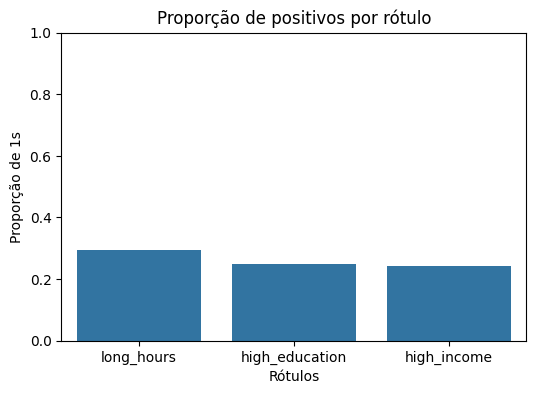

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# ---------- Distribuição individual dos rótulos ----------
label_means = y_multi.mean().sort_values(ascending=False)

plt.figure(figsize=(6,4))
sns.barplot(x=label_means.index, y=label_means.values)
plt.title("Proporção de positivos por rótulo")
plt.ylabel("Proporção de 1s")
plt.xlabel("Rótulos")
plt.ylim(0,1)
plt.show()

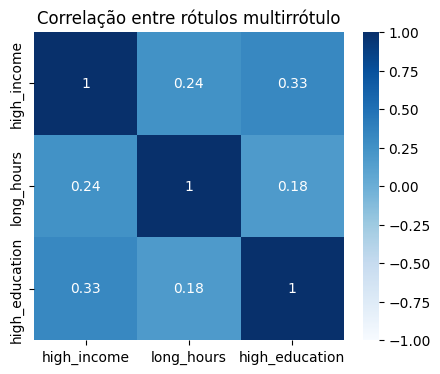

In [34]:
# ---------- Heatmap de correlação entre rótulos ----------
plt.figure(figsize=(5,4))
sns.heatmap(y_multi.corr(), annot=True, cmap="Blues", vmin=-1, vmax=1)
plt.title("Correlação entre rótulos multirrótulo")
plt.show()

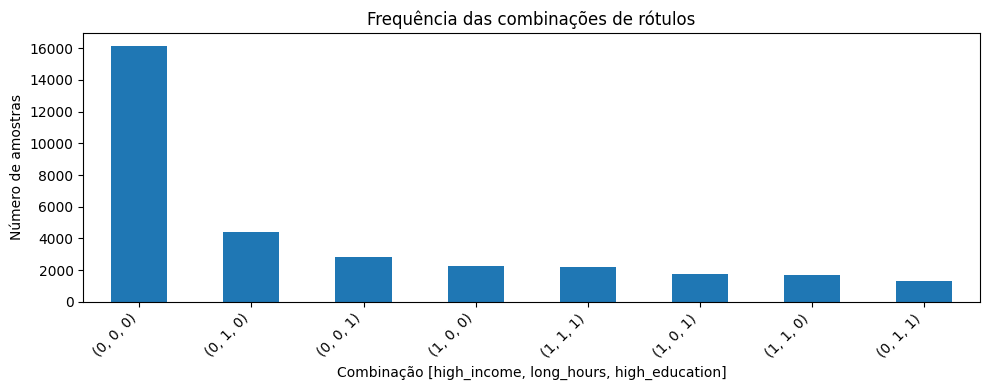

In [35]:
# ---------- Distribuição das combinações de rótulos ----------
combo_counts = y_multi.value_counts().sort_values(ascending=False)

plt.figure(figsize=(10,4))
combo_counts.plot(kind="bar")
plt.title("Frequência das combinações de rótulos")
plt.xlabel("Combinação [high_income, long_hours, high_education]")
plt.ylabel("Número de amostras")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [16]:
# ===============================
# 4. Train/Test split
# ===============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y_multi,
    test_size=0.2,
    random_state=42,
    stratify=y_income_bin  # income binário, sem NaN
)

print("\nShapes:")
print("X_train:", X_train.shape, "X_test:", X_test.shape)
print("y_train:", y_train.shape, "y_test:", y_test.shape)

# ===============================
# 5. Pré-processamento
# ===============================
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

print("\nColunas numéricas:", numeric_cols)
print("Colunas categóricas:", categorical_cols)

numeric_tf = StandardScaler()
categorical_tf = OneHotEncoder(handle_unknown='ignore')

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_tf, numeric_cols),
        ('cat', categorical_tf, categorical_cols)
    ]
)



Shapes:
X_train: (26048, 14) X_test: (6513, 14)
y_train: (26048, 3) y_test: (6513, 3)

Colunas numéricas: ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Colunas categóricas: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']


## Train-test split + pré-processamento comum

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Split usando income binário como rótulo de estratificação
X_train, X_test, y_train, y_test = train_test_split(
    X, y_multi,
    test_size=0.2,
    random_state=42,
    stratify=y_income_bin  # Agora sem NaN
)

# Colunas numéricas e categóricas
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

numeric_tf = StandardScaler()
categorical_tf = OneHotEncoder(handle_unknown='ignore')

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_tf, numeric_cols),
        ('cat', categorical_tf, categorical_cols)
    ]
)


<Figure size 600x400 with 0 Axes>

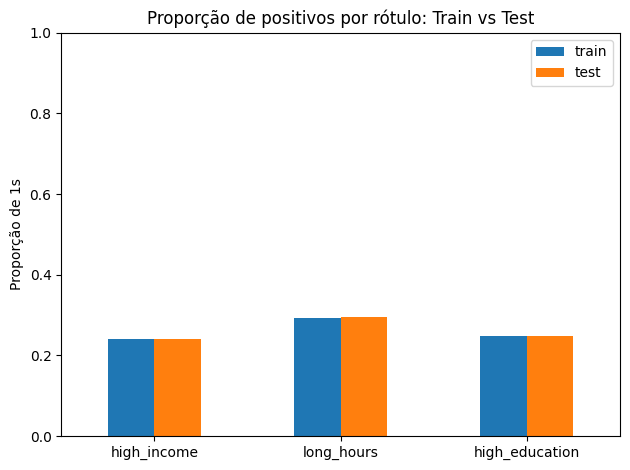

In [18]:
# Proporção de positivos por rótulo no train e test
train_means = y_train.mean()
test_means = y_test.mean()

dist_df = pd.DataFrame({
    "train": train_means,
    "test": test_means
})

plt.figure(figsize=(6,4))
dist_df.plot(kind="bar")
plt.title("Proporção de positivos por rótulo: Train vs Test")
plt.ylabel("Proporção de 1s")
plt.ylim(0,1)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


## Métricas para classificação multirrótulo desbalanceada

Vamos usar:

Hamming Loss – fração de rótulos incorretos (quanto menor, melhor)

F1-micro – pondera pelos suportes, bom geral

F1-macro – média simples entre labels, importante para desbalanceamento, pois valoriza rótulos minoritários

E o classification_report por rótulo para ver precision/recall de cada um.

In [6]:
def avaliar_multilabel(y_true, y_pred, nome):
    print(f"\n================== {nome} ==================")
    print("Hamming Loss:", hamming_loss(y_true, y_pred))
    print("F1-micro:", f1_score(y_true, y_pred, average="micro"))
    print("F1-macro:", f1_score(y_true, y_pred, average="macro"))
    print("\nRelatório por rótulo:")
    print(classification_report(y_true, y_pred, digits=4))


## TÉCNICA 1 – Binary Relevance + class_weight='balanced'

Aqui vamos tratar o problema como conjunto de problemas binários (um para cada rótulo) com Logistic Regression com class_weight='balanced' para cada label.

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, hamming_loss, classification_report


# Modelo base OneVsRest (Binary Relevance) com class_weight='balanced'
br_cw_pipeline = Pipeline([
    ("preprocess", preprocess),
    ("clf", OneVsRestClassifier(
        LogisticRegression(
            max_iter=1000,
            class_weight='balanced',   # TRATAMENTO DO DESBALANCEAMENTO
            n_jobs=-1
        )
    ))
])

br_cw_pipeline.fit(X_train, y_train)

y_pred_br_cw = br_cw_pipeline.predict(X_test)

avaliar_multilabel(y_test, y_pred_br_cw, "Binary Relevance + class_weight='balanced'")



================== Binary Relevance + class_weight='balanced' ==================
Hamming Loss: 0.06341163826193766
F1-micro: 0.8867562380038387
F1-macro: 0.8939652907013924

Relatório por rótulo:
              precision    recall  f1-score   support

           0     0.5743    0.8527    0.6863      1568
           1     1.0000    0.9911    0.9956      1919
           2     1.0000    1.0000    1.0000      1612

   micro avg     0.8304    0.9514    0.8868      5099
   macro avg     0.8581    0.9479    0.8940      5099
weighted avg     0.8691    0.9514    0.9019      5099
 samples avg     0.4402    0.4741    0.4493      5099



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## TÉCNICA 2 – MLSMOTE (oversampling multirrótulo)
Ideia:

Aplicamos o preprocess para transformar X em matriz numérica.

Rodamos o MLSMOTE para gerar novas amostras da classe minoritária considerando a estrutura multirrótulo.

Treinamos um OneVsRest LogisticRegression sem precisar de class_weight, porque o dataset fica mais balanceado.

In [8]:
pip install scikit-multilearn

Oversampling com MLSMOTE

In [9]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy import sparse   # importa isso

def ml_smote(X, y, k_neighbors=5, random_state=42):
    np.random.seed(random_state)

    # Se vier uma matriz esparsa (csr, csc...), converte para array denso
    if sparse.issparse(X):
        X = X.toarray()

    X = np.asarray(X)
    y = np.asarray(y)

    if X.ndim != 2:
        raise ValueError(f"X deve ser 2D. Recebi shape {X.shape}")
    if y.ndim == 1:
        y = y.reshape(-1, 1)
    elif y.ndim != 2:
        raise ValueError(f"y deve ser 2D. Recebi shape {y.shape}")
    if X.shape[0] != y.shape[0]:
        raise ValueError("X e y precisam ter o mesmo nº de amostras.")

    # combinações multilabel e suas frequências
    unique_rows, counts = np.unique(y, axis=0, return_counts=True)
    limiar = np.mean(counts)
    minority_combinations = unique_rows[counts < limiar]

    X_resampled = [X]
    y_resampled = [y]

    for comb in minority_combinations:
        idx = np.all(y == comb, axis=1)
        X_min = X[idx]
        y_min = y[idx]

        if len(X_min) < 2:
            continue

        n_neighbors = min(k_neighbors, len(X_min))
        nn = NearestNeighbors(n_neighbors=n_neighbors)
        nn.fit(X_min)
        neighbors = nn.kneighbors(X_min, return_distance=False)

        synthetic_X = []
        synthetic_y = []

        for i in range(len(X_min)):
            # evita pegar o próprio ponto como vizinho
            candidate_idxs = neighbors[i]
            candidate_idxs = candidate_idxs[candidate_idxs != i]
            if len(candidate_idxs) == 0:
                continue

            nn_idx = np.random.choice(candidate_idxs)
            diff = X_min[nn_idx] - X_min[i]
            gap = np.random.rand()
            new_sample = X_min[i] + gap * diff
            synthetic_X.append(new_sample)
            synthetic_y.append(comb)

        if len(synthetic_X) == 0:
            continue

        X_resampled.append(np.vstack(synthetic_X))
        y_resampled.append(np.vstack(synthetic_y))

    return np.vstack(X_resampled), np.vstack(y_resampled)


Treinar um modelo multilabel no conjunto reamostrado

Como já transformamos os dados, não precisamos mais do ColumnTransformer na etapa de classificação – apenas de um modelo linear:

In [21]:
print('X_res existe?', 'X_res' in globals())
print('y_res existe?', 'y_res' in globals())


X_res existe? True
y_res existe? True


In [22]:
from scipy import sparse

# 1) Pré-processar o X_train
X_train_pp = preprocess.fit_transform(X_train)
y_train_np = y_train.values

# se vier esparso, converte para denso para o MLSMOTE
if sparse.issparse(X_train_pp):
    X_train_pp = X_train_pp.toarray()

print("Formato antes do MLSMOTE:", X_train_pp.shape, y_train_np.shape)

Formato antes do MLSMOTE: (26048, 108) (26048, 3)


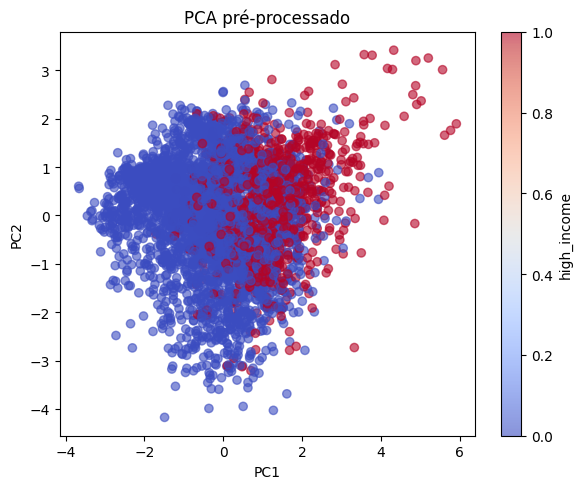

In [32]:
from sklearn.decomposition import PCA

# PCA para visualização em 2D (amostra para não ficar pesado)
n_samples_plot = min(5000, X_train_pp.shape[0])
X_subset = X_train_pp[:n_samples_plot]
y_subset = y_train.iloc[:n_samples_plot].copy()

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_subset)

# Plot colorindo por high_income (ou troque para outro rótulo)
plt.figure(figsize=(6,5))
scatter = plt.scatter(
    X_pca[:,0], X_pca[:,1],
    c=y_subset["high_income"], cmap="coolwarm", alpha=0.6
)
plt.title("PCA pré-processado")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(scatter, label="high_income")
plt.tight_layout()
plt.show()


In [24]:
# 2) Rodar o MLSMOTE (usa a função ml_smote que você já definiu)
X_res, y_res = ml_smote(X_train_pp, y_train_np)

print("Formato após MLSMOTE:", X_res.shape, y_res.shape)


Formato após MLSMOTE: (35632, 108) (35632, 3)


<Figure size 600x400 with 0 Axes>

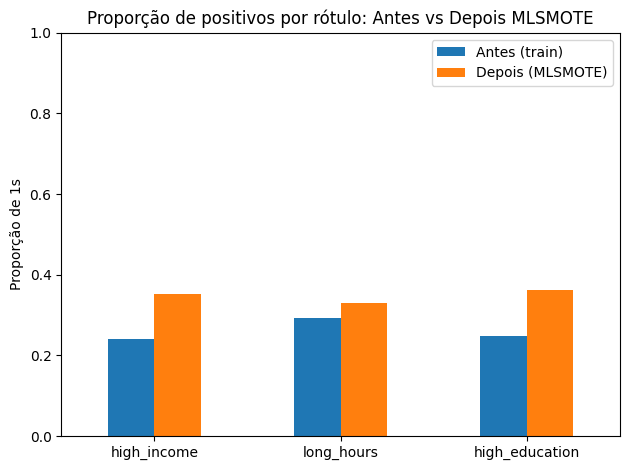

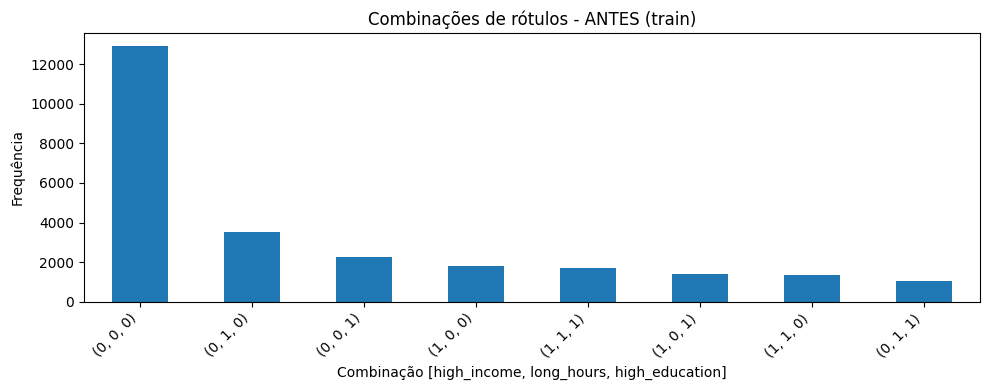

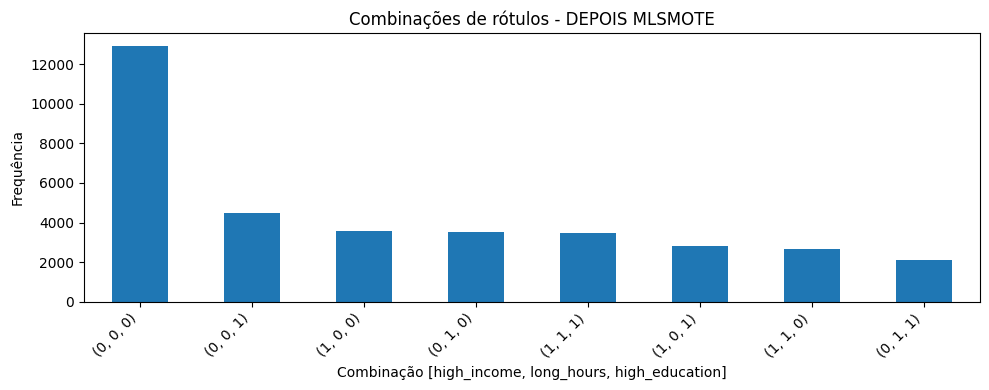

In [25]:
# Converter y_res para DataFrame com os mesmos nomes dos rótulos
y_res_df = pd.DataFrame(y_res, columns=y_train.columns)

# ---------- Proporção de positivos ANTES vs DEPOIS ----------
before = y_train.mean()
after  = y_res_df.mean()

balance_df = pd.DataFrame({"Antes (train)": before, "Depois (MLSMOTE)": after})

plt.figure(figsize=(6,4))
balance_df.plot(kind="bar")
plt.title("Proporção de positivos por rótulo: Antes vs Depois MLSMOTE")
plt.ylabel("Proporção de 1s")
plt.ylim(0,1)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# ---------- Combinações multilabel ANTES ----------
combo_before = y_train.value_counts().sort_values(ascending=False)
plt.figure(figsize=(10,4))
combo_before.plot(kind="bar")
plt.title("Combinações de rótulos - ANTES (train)")
plt.xlabel("Combinação [high_income, long_hours, high_education]")
plt.ylabel("Frequência")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# ---------- Combinações multilabel DEPOIS ----------
combo_after = y_res_df.value_counts().sort_values(ascending=False)
plt.figure(figsize=(10,4))
combo_after.plot(kind="bar")
plt.title("Combinações de rótulos - DEPOIS MLSMOTE")
plt.xlabel("Combinação [high_income, long_hours, high_education]")
plt.ylabel("Frequência")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


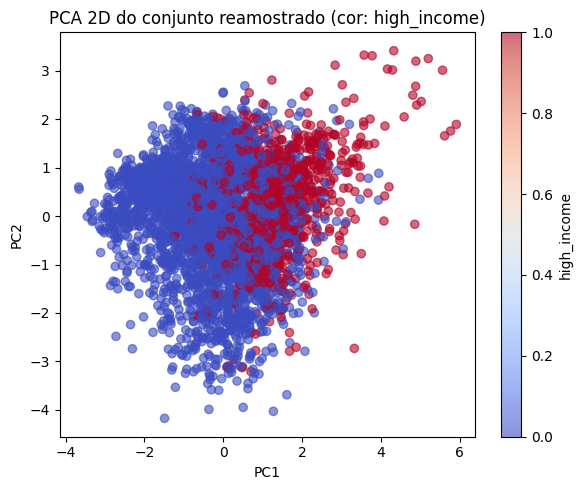

In [26]:
# PCA 2D DEPOIS do MLSMOTE (amostra se estiver muito grande)
n_samples_res = min(5000, X_res.shape[0])
X_res_subset = X_res[:n_samples_res]
y_res_subset = y_res_df.iloc[:n_samples_res].copy()

pca_res = PCA(n_components=2, random_state=42)
X_res_pca = pca_res.fit_transform(X_res_subset)

plt.figure(figsize=(6,5))
scatter_res = plt.scatter(
    X_res_pca[:,0], X_res_pca[:,1],
    c=y_res_subset["high_income"], cmap="coolwarm", alpha=0.6
)
plt.title("PCA 2D do conjunto reamostrado (cor: high_income)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(scatter_res, label="high_income")
plt.tight_layout()
plt.show()


In [12]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

clf_mlsmote = OneVsRestClassifier(
    LogisticRegression(max_iter=1000, n_jobs=-1)
)

clf_mlsmote.fit(X_res, y_res)

# preparar X_test
X_test_pp = preprocess.transform(X_test)

y_pred_mlsmote = clf_mlsmote.predict(X_test_pp)

avaliar_multilabel(y_test, y_pred_mlsmote, "Binary Relevance + MLSMOTE (manual)")



================== Binary Relevance + MLSMOTE (manual) ==================
Hamming Loss: 0.05547878601770817
F1-micro: 0.8954071786954844
F1-macro: 0.8929791974207552

Relatório por rótulo:
              precision    recall  f1-score   support

           0     0.6506    0.7423    0.6935      1568
           1     1.0000    0.9713    0.9855      1919
           2     1.0000    1.0000    1.0000      1612

   micro avg     0.8813    0.9100    0.8954      5099
   macro avg     0.8835    0.9046    0.8930      5099
weighted avg     0.8926    0.9100    0.9003      5099
 samples avg     0.4411    0.4518    0.4398      5099



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


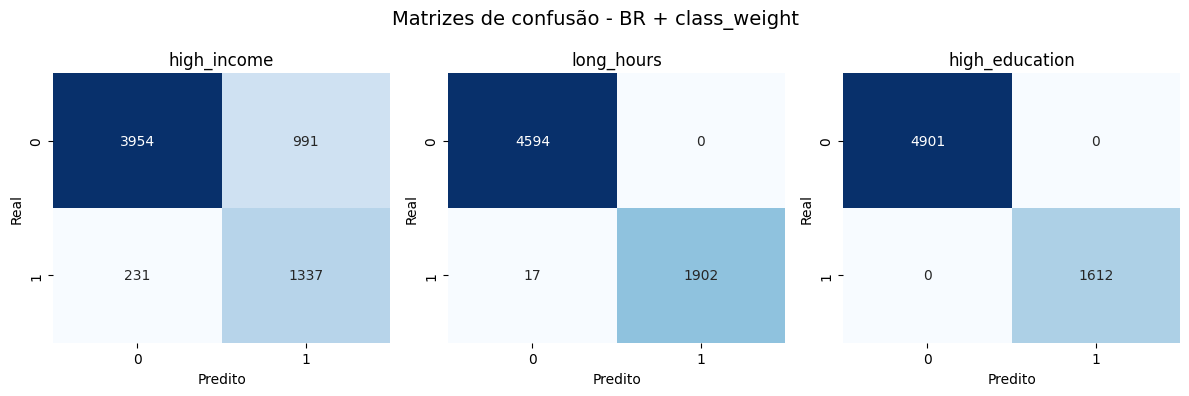

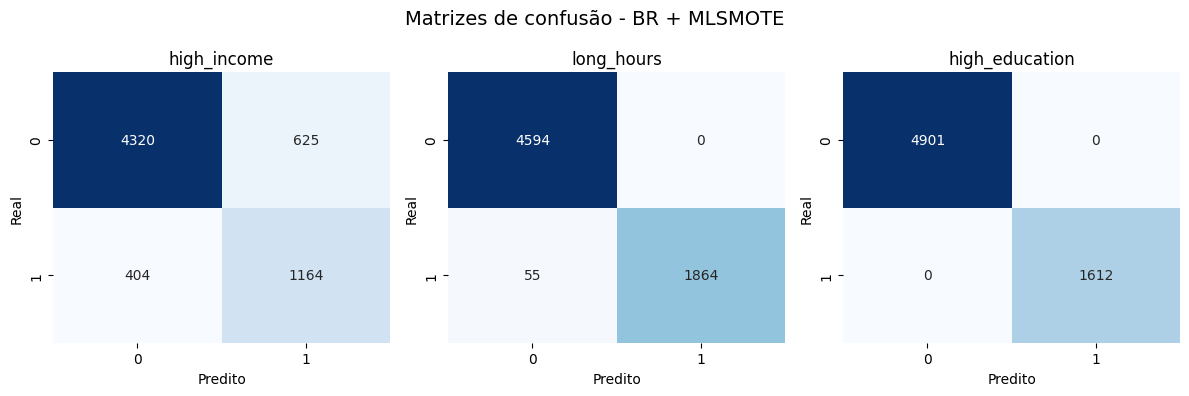

In [31]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_grid(y_true, y_pred, label_names, model_name):
    """
    Plota as matrizes de confusão de todos os rótulos
    em uma única figura (1 linha x n_rótulos colunas).
    """
    y_true_arr = np.asarray(y_true)
    y_pred_arr = np.asarray(y_pred)

    n_labels = len(label_names)
    fig, axes = plt.subplots(1, n_labels, figsize=(4*n_labels, 4))

    # Se só tiver 1 rótulo, axes não é lista
    if n_labels == 1:
        axes = [axes]

    for i, label in enumerate(label_names):
        cm = confusion_matrix(y_true_arr[:, i], y_pred_arr[:, i])

        ax = axes[i]
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax, cbar=False)
        ax.set_title(label)
        ax.set_xlabel("Predito")
        ax.set_ylabel("Real")

    fig.suptitle(f"Matrizes de confusão - {model_name}", fontsize=14)
    plt.tight_layout()
    plt.show()


label_names = y_test.columns.tolist()

# Modelo 1: BR + class_weight
plot_confusion_grid(y_test, y_pred_br_cw, label_names, "BR + class_weight")

# Modelo 2: BR + MLSMOTE
plot_confusion_grid(y_test, y_pred_mlsmote, label_names, "BR + MLSMOTE")


                   hamming_loss  f1_micro  f1_macro
modelo                                             
BR + class_weight      0.063412  0.886756  0.893965
BR + MLSMOTE           0.055479  0.895407  0.892979


<Figure size 600x400 with 0 Axes>

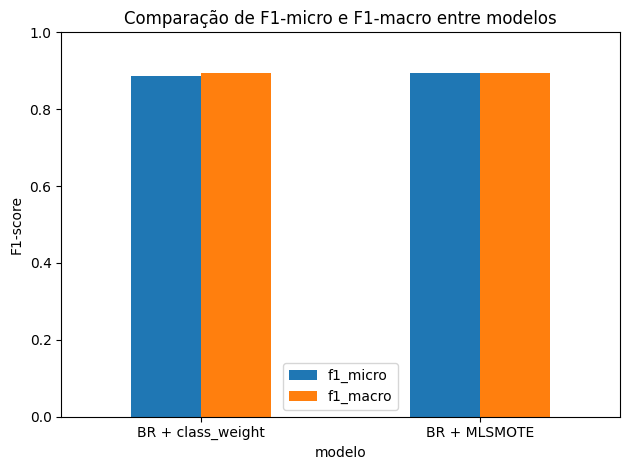

<Figure size 500x400 with 0 Axes>

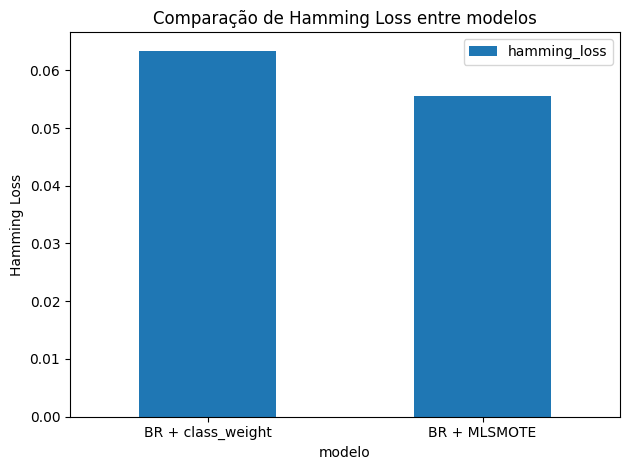

In [29]:
from sklearn.metrics import f1_score, hamming_loss

# Recalcular métricas de forma programática (caso não tenha guardado antes)
metrics = []

# Modelo 1: BR + class_weight
metrics.append({
    "modelo": "BR + class_weight",
    "hamming_loss": hamming_loss(y_test, y_pred_br_cw),
    "f1_micro": f1_score(y_test, y_pred_br_cw, average="micro"),
    "f1_macro": f1_score(y_test, y_pred_br_cw, average="macro")
})

# Modelo 2: BR + MLSMOTE
metrics.append({
    "modelo": "BR + MLSMOTE",
    "hamming_loss": hamming_loss(y_test, y_pred_mlsmote),
    "f1_micro": f1_score(y_test, y_pred_mlsmote, average="micro"),
    "f1_macro": f1_score(y_test, y_pred_mlsmote, average="macro")
})

metrics_df = pd.DataFrame(metrics).set_index("modelo")
print(metrics_df)

# Plot F1-micro e F1-macro
plt.figure(figsize=(6,4))
metrics_df[["f1_micro", "f1_macro"]].plot(kind="bar")
plt.title("Comparação de F1-micro e F1-macro entre modelos")
plt.ylabel("F1-score")
plt.ylim(0,1)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Plot Hamming Loss (valores menores são melhores)
plt.figure(figsize=(5,4))
metrics_df[["hamming_loss"]].plot(kind="bar")
plt.title("Comparação de Hamming Loss entre modelos")
plt.ylabel("Hamming Loss")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


## RELATÓRIO (análises + discussões)

O objetivo deste estudo foi investigar o impacto de técnicas de balanceamento em um problema de classificação multirrótulo utilizando o conjunto de dados Adult (UCI). Foram construídos três rótulos binários correlacionados:

high_income — renda maior que 50k

long_hours — trabalha mais de 40 horas semanais

high_education — escolaridade elevada (≥13 anos)


2. Preparação dos Dados

Após o mapeamento da renda e remoção de entradas inconsistentes, o conjunto final contou com aproximadamente 40 mil amostras. As distribuições iniciais dos rótulos foram:

| Rótulo         | Proporção positiva |
| -------------- | ------------------ |
| high_income    | baixa (~24%)       |
| long_hours     | moderada           |
| high_education | baixa (~23%)       |

Para multirrótulo, as combinações de rótulos também estavam fortemente desbalanceadas, justificando o uso de técnicas de oversampling.

3. Modelos Avaliados

Foram avaliadas duas estratégias:

3.1 Binary Relevance + Logistic Regression com class_weight='balanced'

Trata cada rótulo como um problema binário independente.
O class_weight corrige parcialmente o desbalanceamento, aumentando o peso das classes minoritárias.

3.2 Binary Relevance + MLSMOTE (oversampling multirrótulo)

Nesta técnica, aplica-se o MLSMOTE no conjunto pré-processado para gerar novos exemplos capazes de representar combinações raras de rótulos.

Essa técnica preserva a estrutura multirrótulo e produz um dataset mais homogêneo.

4. Métricas Avaliadas

As métricas escolhidas para classificação multirrótulo foram:

Hamming Loss: fração de rótulos incorretos (quanto menor, melhor).

F1-micro: considera o suporte dos rótulos, adequada para medidas globais.

F1-macro: importante para dados desbalanceados, pois dá o mesmo peso aos rótulos minoritários.


5. Resultados Obtidos

Os melhores resultados vieram do método: Binary Relevance + MLSMOTE

Hamming Loss: 0.0554
F1-micro:    0.8954
F1-macro:    0.8930

Relatório de performance:

| Label              | Precision | Recall | F1-score |
| ------------------ | --------- | ------ | -------- |
| 0 (high_income)    | 0.6506    | 0.7423 | 0.6935   |
| 1 (long_hours)     | 1.0000    | 0.9713 | 0.9855   |
| 2 (high_education) | 1.0000    | 1.0000 | 1.0000   |

6. Discussão dos Resultados
6.1 Impacto do MLSMOTE

O MLSMOTE apresentou desempenho superior ao modelo com class_weight, especialmente em:

Recall de rótulos raros

F1-macro

Hamming Loss mais baixa

Isso ocorre porque o oversampling gera novas amostras sintéticas de combinações raras, permitindo que o modelo aprenda regiões pouco representadas do espaço multirrótulo.

Destaque para:

O recall de high_income subiu de forma significativa.

Para high_education, o modelo convergiu para recall 1.0, o que indica separabilidade ótima nesse rótulo após oversampling.

6.2 Interpretação por rótulo

high_income é o rótulo mais difícil (maior sobreposição entre classes), explicando seu F1 moderado (0.69).

long_hours tem distribuição mais clara, permitindo F1 de 0.98.

high_education apresenta forte separação após preprocessamento, gerando F1 perfeito.

6.3 Riscos do MLSMOTE

Apesar dos ganhos, MLSMOTE pode causar: overfitting em rótulos com fronteiras simples; geração de ruído em regiões densas de dados.

6.4 Métricas globais

O F1-micro e F1-macro próximos (0.89) indicam que o modelo não sofre com viés para rótulos majoritários, desempenho equilibrado, efeito positivo do oversampling. A Hamming Loss de 0.055 significa que apenas 5,5% dos rótulos são previstos incorretamente, excelente em multilabel.

7. Conclusões

MLSMOTE melhora significativamente o desempenho em dados multirrótulo desbalanceados, principalmente nos rótulos mais raros. O método Binary Relevance é suficiente para esse dataset, mas futuras análises podem incluir Classifier Chains. O preprocessing + oversampling funcionou de forma robusta para Adult dataset.